In [1]:
ls

data/  data_copy/  data.zip  Graph/  output_data/  Plant Seedlings.ipynb


In [2]:
from tqdm import tqdm
import requests

def download_file(url, out_file):

    chunk_size = 1024
    r = requests.get(url, stream=True)
    total_size = int(r.headers['content-length'])

    with open(out_file, 'wb') as f:
        for data in tqdm(iterable=r.iter_content(chunk_size=chunk_size),
                         total=total_size/chunk_size, unit='KB'):
            f.write(data)

    print('{} download Complete!'.format(out_file))

In [3]:
url = 'https://vision.eng.au.dk/?download=/data/WeedData/NonsegmentedV2.zip'
zip_file = './data.zip'
data_path = './data'

import os

if not os.path.isfile(zip_file):
    download_file(url, zip_file)

In [4]:
ls

data/  data_copy/  data.zip  Graph/  output_data/  Plant Seedlings.ipynb


In [5]:
from zipfile import ZipFile

if not os.path.isdir(data_path):
    with ZipFile(zip_file, 'r') as f:
        print('Extracting all the files now ...')
        f.extractall('./data')
        print('Done!')

In [6]:
ls

data/  data_copy/  data.zip  Graph/  output_data/  Plant Seedlings.ipynb


In [7]:
ls data/

Black-grass/  Common Chickweed/  Loose Silky-bent/   Shepherd’s Purse/
Charlock/     Common wheat/      Maize/              Small-flowered Cranesbill/
Cleavers/     Fat Hen/           Scentless Mayweed/  Sugar beet/


In [8]:
labels_list = os.listdir(data_path)
num_labels = len(labels_list)

print('Labels:')

for idx, label in enumerate(labels_list):
    print('{}. {}'.format(idx+1, label))

Labels:
1. Shepherd’s Purse
2. Cleavers
3. Maize
4. Fat Hen
5. Black-grass
6. Charlock
7. Sugar beet
8. Small-flowered Cranesbill
9. Common wheat
10. Loose Silky-bent
11. Scentless Mayweed
12. Common Chickweed


In [9]:
import matplotlib.pyplot as plt
import glob

images_count = []
y = []

plt.figure(1)

print('No of images in:')

for idx, label in enumerate(labels_list):
    label_path = os.path.join(data_path, label)
    images_list = glob.glob(os.path.join(label_path, '*.png'))
    num_images = len(images_list)
    images_count.append(num_images)
    img_path = images_list[0]
    img = plt.imread(img_path)
    y += [label] * num_images

    plt.subplot(3,4,idx+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

    print('{} directory: {}'.format(label, num_images))

print()
plt.show()

No of images in:
Shepherd’s Purse directory: 274
Cleavers directory: 335
Maize directory: 257
Fat Hen directory: 538
Black-grass directory: 309
Charlock directory: 452
Sugar beet directory: 463
Small-flowered Cranesbill directory: 576
Common wheat directory: 253
Loose Silky-bent directory: 762
Scentless Mayweed directory: 607
Common Chickweed directory: 713



<Figure size 640x480 with 12 Axes>

In [10]:
avg_img = sum(images_count)//len(images_count)

print(avg_img)

461


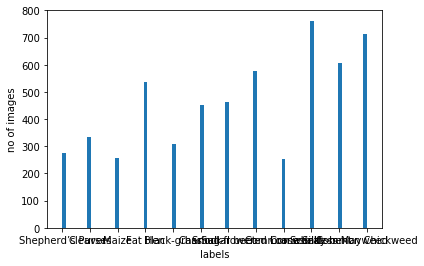

In [11]:
def plot_num_images(y):
    plt.hist(y, bins=86)
    plt.xlabel('labels')
    plt.ylabel('no of images')
    plt.show()

In [ ]:
plot_num_images(y)

In [12]:
from subprocess import call

if not os.path.isdir('./data_copy'):
    _ = call(['cp', '-a', data_path, './data_copy'])

data_path = './data_copy'

In [13]:
ls

data/  data_copy/  data.zip  Graph/  output_data/  Plant Seedlings.ipynb


In [14]:
import Augmentor

def augment_images(path, num):
    p = Augmentor.Pipeline(path, '.', save_format='png')
    p.random_brightness(.5, .25, .75)
    p.random_color(.5, .25, .75)
    p.random_contrast(.5, .25, .75)
    p.rotate(.5, 10, 10)
    p.sample(avg_img - num)

In [15]:
import os

labels_list = os.listdir(data_path)

if len(os.listdir('./data_copy/Black-grass')) < avg_img+1:
    
    for label in labels_list:
        label_path = os.path.join(data_path, label)
        num_images = os.listdir(label_path)
        if len(num_images) < avg_img:
            augment_images(label_path, len(num_images)) 

No of images in:
Shepherd’s Purse directory: 461
Cleavers directory: 461
Maize directory: 461
Fat Hen directory: 538
Black-grass directory: 461
Charlock directory: 461
Sugar beet directory: 463
Small-flowered Cranesbill directory: 576
Common wheat directory: 461
Loose Silky-bent directory: 762
Scentless Mayweed directory: 607
Common Chickweed directory: 713



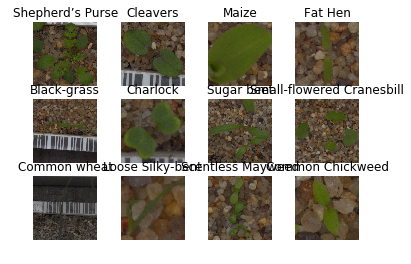

In [16]:
import matplotlib.pyplot as plt
import glob

X = []
y = []

plt.figure(1)

print('No of images in:')

for idx, label in enumerate(labels_list):
    label_path = os.path.join(data_path, label)
    images_list = glob.glob(os.path.join(label_path, '*.png'))
    num_images = len(images_list)
    X += images_list
    y += [label] * num_images
    img_path = images_list[0]
    img = plt.imread(img_path)

    plt.subplot(3,4,idx+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

    print('{} directory: {}'.format(label, num_images))

print()
plt.show()

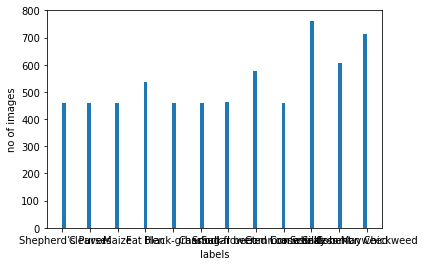

In [17]:
plot_num_images(y)

In [18]:
import os
import json
import numpy as np

from keras.models import Model, load_model
from keras.layers import Dense, Flatten
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.applications.vgg19 import VGG19, preprocess_input
from keras import optimizers

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
output_path = './output_data'
log_file = os.path.join(output_path, 'log.csv')

full_model_path = os.path.join(output_path, 'plant_vgg19.h5')
cross_model_path = os.path.join(output_path, 'plant_vgg19_cross.h5')

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
n_splits = 3

batch_size = 32
epochs = 10

In [20]:
## Split data

X, y = shuffle(X, y)

X, X_valid, y, y_valid = train_test_split(X, y, test_size=0.1,
                                          random_state=0, stratify=y)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2,
                                        random_state=0, stratify=y)

print('Train:', len(X), len(y))
print('Valid:', len(X_valid), len(y_valid))
print('Test:', len(X_test), len(y_test))
print(type(X), type(y))

Train: 4625 4625
Valid: 643 643
Test: 1157 1157
<class 'list'> <class 'list'>


In [21]:
# Load model
# include_top is used to remove all the layers after block conv5

model = VGG19(include_top=False, input_shape=(299, 299, 3))

# Freeze all layers
for layer in model.layers:
    layer.trainable = False

# re-add the removed layers
x = model.output
x = Flatten(name="flatten")(x)
x = Dense(4096, activation="relu", name="fc1")(x)
x = Dense(4096, activation="relu", name="fc2")(x)
x = Dense(num_labels, activation="softmax", name="predictions")(x)

# Redefine the model
model = Model(inputs=model.input, outputs=x, name="final_model")

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

In [23]:
from keras import backend as K

def precision_micro(y_true, y_pred):
    tp = K.sum(y_true * y_pred)
    fp = K.sum(y_pred * K.cast(K.equal(y_true, K.zeros_like(y_true)), "float32"))
    return tp / (tp + fp + K.epsilon())


def recall_micro(y_true, y_pred):
    tp = K.sum(y_true * y_pred)
    fn = K.sum(y_true * K.cast(K.equal(y_pred, K.zeros_like(y_pred)), "float32"))
    return tp / (tp + fn + K.epsilon())


def f1_micro(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred = K.one_hot(y_pred, 12)
    pm = precision_micro(y_true, y_pred)
    rm = recall_micro(y_true, y_pred)
    return (2 * pm * rm) / (pm + rm + K.epsilon())

In [24]:
adam = optimizers.Adam(lr=0.0001)

# compile the model
model.compile(optimizer=adam, loss='categorical_crossentropy', 
              metrics=['accuracy', precision_micro, recall_micro, f1_micro])

In [25]:
# Callbacks

from keras.callbacks import TensorBoard
from keras.callbacks import TerminateOnNaN
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger

# TerminateOnNaN
terminate_callback = TerminateOnNaN()

# Tensorboard
tb_callback = TensorBoard('./Graph', histogram_freq=0, write_graph=True, write_images=True)

# Model Checkppoint
ckpt_callback = ModelCheckpoint('./output_data/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                                verbose=1, save_weights_only=False, mode='auto', period=5)

# Early Stopping
#stopping_callback = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')

# CSV Logger
csv_logger = CSVLogger('./training.log')

# Callbacks list
callbacks = [terminate_callback, tb_callback, ckpt_callback, csv_logger]

Instructions for updating:
Use the retry module or similar alternatives.


In [26]:
## Data generator

def data_generator(X, y, batch_size):

    idx = 0
    
    encoder = LabelBinarizer()
    y = encoder.fit_transform(y)

    num_batches = len(X)//batch_size

    while True:
        start = idx * batch_size
        end = start + batch_size

        batch_X = []
        batch_y = y[start:end, :]

        for filename in X[start:end]:
            img = image.load_img(filename, target_size=(299, 299, 3))
            img = image.img_to_array(img)
            batch_X.append(img)

        batch_X = np.array(batch_X)
        batch_X = preprocess_input(batch_X)
        batch_X /= 255
        
        idx += 1

        yield batch_X, batch_y

        if idx == num_batches:
            idx = 0

In [ ]:
def plot_model(histories):
    plots = [i for i in histories[0].history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(15,25))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(histories[0].history[p], label=p)
        plt.plot(histories[0].history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()

In [27]:
## Cross Validation

import pickle

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

if not os.path.isfile(cross_model_path):

    # Training
    print("Start cross-validation training...")

    histories = []

    temp_X = np.array(X)
    temp_y = np.array(y)

    for train, val in skf.split(temp_X, temp_y):
        train_datagen = data_generator(temp_X[train], temp_y[train], batch_size)
        valid_datagen = data_generator(temp_X[val], temp_y[val], batch_size)

        history = model.fit_generator(train_datagen, steps_per_epoch=len(train)//batch_size,
                    validation_data=valid_datagen, epochs=epochs, 
                                     validation_steps = len(val)//batch_size)
        histories.append(history)

    model.save(cross_model_path)
    
    del model
    
    with open('cross_train_histories.data', 'wb') as f:
        pickle.dump(histories, f)

Start cross-validation training...
Epoch 1/5
96/96 [==============================] - 62s 650ms/step - loss: 2.2997 - acc: 0.2510 - f1_micro: 0.2510 - val_loss: 1.7719 - val_acc: 0.3828 - val_f1_micro: 0.3828
Epoch 2/5
96/96 [==============================] - 55s 573ms/step - loss: 1.4928 - acc: 0.4941 - f1_micro: 0.4941 - val_loss: 1.3817 - val_acc: 0.5273 - val_f1_micro: 0.5273
Epoch 3/5
96/96 [==============================] - 55s 578ms/step - loss: 1.1131 - acc: 0.6195 - f1_micro: 0.6195 - val_loss: 1.2500 - val_acc: 0.5749 - val_f1_micro: 0.5749
Epoch 4/5
96/96 [==============================] - 56s 581ms/step - loss: 0.8963 - acc: 0.7005 - f1_micro: 0.7005 - val_loss: 1.2184 - val_acc: 0.5840 - val_f1_micro: 0.5840
Epoch 5/5
96/96 [==============================] - 56s 585ms/step - loss: 0.7805 - acc: 0.7318 - f1_micro: 0.7318 - val_loss: 1.1044 - val_acc: 0.6061 - val_f1_micro: 0.6061
Epoch 1/5
96/96 [==============================] - 56s 585ms/step - loss: 0.9611 - acc: 0.6712 

In [ ]:
with open('cross_train_histories.data', 'rb') as f:
    histories = pickle.load(f)
    plot_model(histories)

In [28]:
## Full Training

batch_size = 32

epochs = 20

model = load_model(cross_model_path, custom_objects={'f1_micro':f1_micro, 'precision_micro':precision_micro, 
                                                     'recall_micro':recall_micro})

if not os.path.isfile(full_model_path):

    print("Full training...")

    train_datagen = data_generator(X, y, batch_size)
    valid_datagen = data_generator(X_valid, y_valid, batch_size)

    history = model.fit_generator(train_datagen, steps_per_epoch=len(X)//batch_size,
                        epochs=epochs, callbacks = callbacks,
                        validation_data=valid_datagen, validation_steps=len(X_valid)//batch_size)

    histories.append(history)

    print("Save whole model...")
    model.save(full_model_path)
    
    with open('full_train_histories.data', 'wb') as f:
        pickle.dump(histories, f)


Full training...
Epoch 1/10
144/144 [==============================] - 69s 477ms/step - loss: 0.4198 - acc: 0.8533 - f1_micro: 0.8533 - val_loss: 1.4408 - val_acc: 0.6094 - val_f1_micro: 0.6094
Epoch 2/10
144/144 [==============================] - 68s 471ms/step - loss: 0.3920 - acc: 0.8668 - f1_micro: 0.8668 - val_loss: 1.5467 - val_acc: 0.5938 - val_f1_micro: 0.5937
Epoch 3/10
144/144 [==============================] - 68s 470ms/step - loss: 0.3650 - acc: 0.8750 - f1_micro: 0.8750 - val_loss: 1.7906 - val_acc: 0.5813 - val_f1_micro: 0.5812
Epoch 4/10
144/144 [==============================] - 68s 471ms/step - loss: 0.3371 - acc: 0.8835 - f1_micro: 0.8835 - val_loss: 1.7234 - val_acc: 0.6016 - val_f1_micro: 0.6016
Epoch 5/10
144/144 [==============================] - 68s 471ms/step - loss: 0.3238 - acc: 0.8898 - f1_micro: 0.8898 - val_loss: 1.4702 - val_acc: 0.6375 - val_f1_micro: 0.6375

Epoch 00005: saving model to ./output_data/weights.05-1.47.hdf5
Epoch 6/10
144/144 [=============

In [ ]:
with open('full_train_histories.data', 'rb') as f:
    histories = pickle.load(f)
    plot_model(histories)

In [29]:
## Evaluate

batch_size = 16

model = load_model(full_model_path, custom_objects={'f1_micro':f1_micro})

test_datagen = data_generator(X_test, y_test, batch_size)

Eval = model.evaluate_generator(test_datagen, steps = len(X_test)//batch_size, workers=12)    
print(Eval)

[1.3226926146696012, 0.6796875, 0.6796874403953552]
